# WUSTL dust concentration data exploration 
Using xarray and hvplot, we can create some beautiful visualizations of the WUSTL data. This allows for a better sense of the spatial and temporal distrubution of the data. 

In [1]:
import xarray as xr 
import pandas as pd 
import hvplot.pandas
import numpy as np 
import os 
from glob import glob
import geopandas as gpd
import rioxarray

# Plotting dependencies
import cartopy.crs as ccrs
from textwrap import wrap
import hvplot.xarray
import holoviews as hv
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh # Helps avoid some weird issues with the polar projection 
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150 # Sets figure size in the notebook
plt.rcParams['savefig.facecolor']='white' # Make background white (not transparent)

In [2]:
def read_wusl_ncs(year, data_dir, geometry=None): 
    """ Read netcdf files from Monthly V4.NA.02 PM2.5 composition described in van Donkelaar et al., ES&T 2019
    Merge files to form a single xr.Dataset object 
    
    Args: 
        year (str): year to read in data for 
        data_dir (str): directory containing netcdf files 
        geometry (optional): geometry to clip dataset to (default to None)
        
    Returns: 
        dsAll (xr.Dataset): data 
    
    """
    
    # Get filepaths 
    wildcard = data_dir+year+"/*"+year+"*.nc"
    filepaths = glob(wildcard)
    if len(filepaths) == 0: 
        raise ValueError(f'No files found with wildcard pattern {wildcard}')

    # Loop through each filepath and read in data 
    # You need to do it this way instead of simply xr.open_mfdataset because the files don't have a time coordinate :/
    xr_list = []
    for filename in filepaths:

        # Open file 
        ds = xr.open_dataset(filename)

        # Use filename to assign time coordinate
        print("Reading file " +filename)
        mon_str = filename.split("GWRwSPEC_SOIL_NA_"+year)[1][:2] # Get month from filename
        date = pd.to_datetime(year+mon_str, format=("%Y%m")) # Make pd datetime using yr and mon str 
        ds = ds.assign_coords({"time":date}) # Set time coord
        ds = ds.expand_dims("time") # Set time dimension
        
        # Clip to input geometry 
        if geometry is not None: 
            ds = ds.rio.write_crs("EPSG:4326")
            ds = ds.rio.clip(geometry)

        # Append to list 
        xr_list.append(ds)

    # Merge to form a single xr Dataset object
    dsAll = xr.merge(xr_list)
    return dsAll

In [3]:
# User inputs 
year = 2016 # Year to get data for 
figs_dir = "data/figs" # Where to save output figures

# Make output figure directory 
if not os.path.exists(figs_dir):
    os.makedirs(figs_dir)

# Read in shapefile 
US_states = gpd.read_file("data/cb_2018_us_state_5m")
CA_geom = US_states[US_states["NAME"]=="California"].geometry # Extract CA geometry 

# Read in netcdf files. Clip to CA geometry 
dust_ds = read_wusl_ncs(year=str(year), 
                        data_dir = "data/SOIL/", 
                        geometry=CA_geom)
display(dust_ds)

Reading file data/SOIL/2016/GWRwSPEC_SOIL_NA_201603_201603.nc
Reading file data/SOIL/2016/GWRwSPEC_SOIL_NA_201609_201609.nc
Reading file data/SOIL/2016/GWRwSPEC_SOIL_NA_201601_201601.nc
Reading file data/SOIL/2016/GWRwSPEC_SOIL_NA_201608_201608.nc
Reading file data/SOIL/2016/GWRwSPEC_SOIL_NA_201602_201602.nc
Reading file data/SOIL/2016/GWRwSPEC_SOIL_NA_201604_201604.nc
Reading file data/SOIL/2016/GWRwSPEC_SOIL_NA_201610_201610.nc
Reading file data/SOIL/2016/GWRwSPEC_SOIL_NA_201607_201607.nc
Reading file data/SOIL/2016/GWRwSPEC_SOIL_NA_201612_201612.nc
Reading file data/SOIL/2016/GWRwSPEC_SOIL_NA_201606_201606.nc
Reading file data/SOIL/2016/GWRwSPEC_SOIL_NA_201611_201611.nc
Reading file data/SOIL/2016/GWRwSPEC_SOIL_NA_201605_201605.nc


<xarray.Dataset>
Dimensions:      (time: 12, LAT: 948, LON: 1028)
Coordinates:
  * time         (time) datetime64[ns] 2016-01-01 2016-02-01 ... 2016-12-01
  * LAT          (LAT) float64 42.01 41.99 41.99 41.97 ... 32.56 32.54 32.53
  * LON          (LON) float64 -124.4 -124.4 -124.4 ... -114.2 -114.1 -114.1
    spatial_ref  int64 0
Data variables:
    SOIL         (time, LAT, LON) float32 nan nan nan nan ... nan nan nan nan

In [4]:
# Get CA cities 
pd_ca_cities = pd.read_csv("data/cal_cities_lat_long.csv")
ca_cities = gpd.GeoDataFrame(pd_ca_cities, geometry=gpd.points_from_xy(pd_ca_cities.Longitude, pd_ca_cities.Latitude))
cities_of_interest = ["Fresno","Bakersfield","Sacramento","Los Angeles","San Diego","San Luis Obispo"]
relevant_cities = ca_cities[ca_cities["Name"].isin(cities_of_interest)]

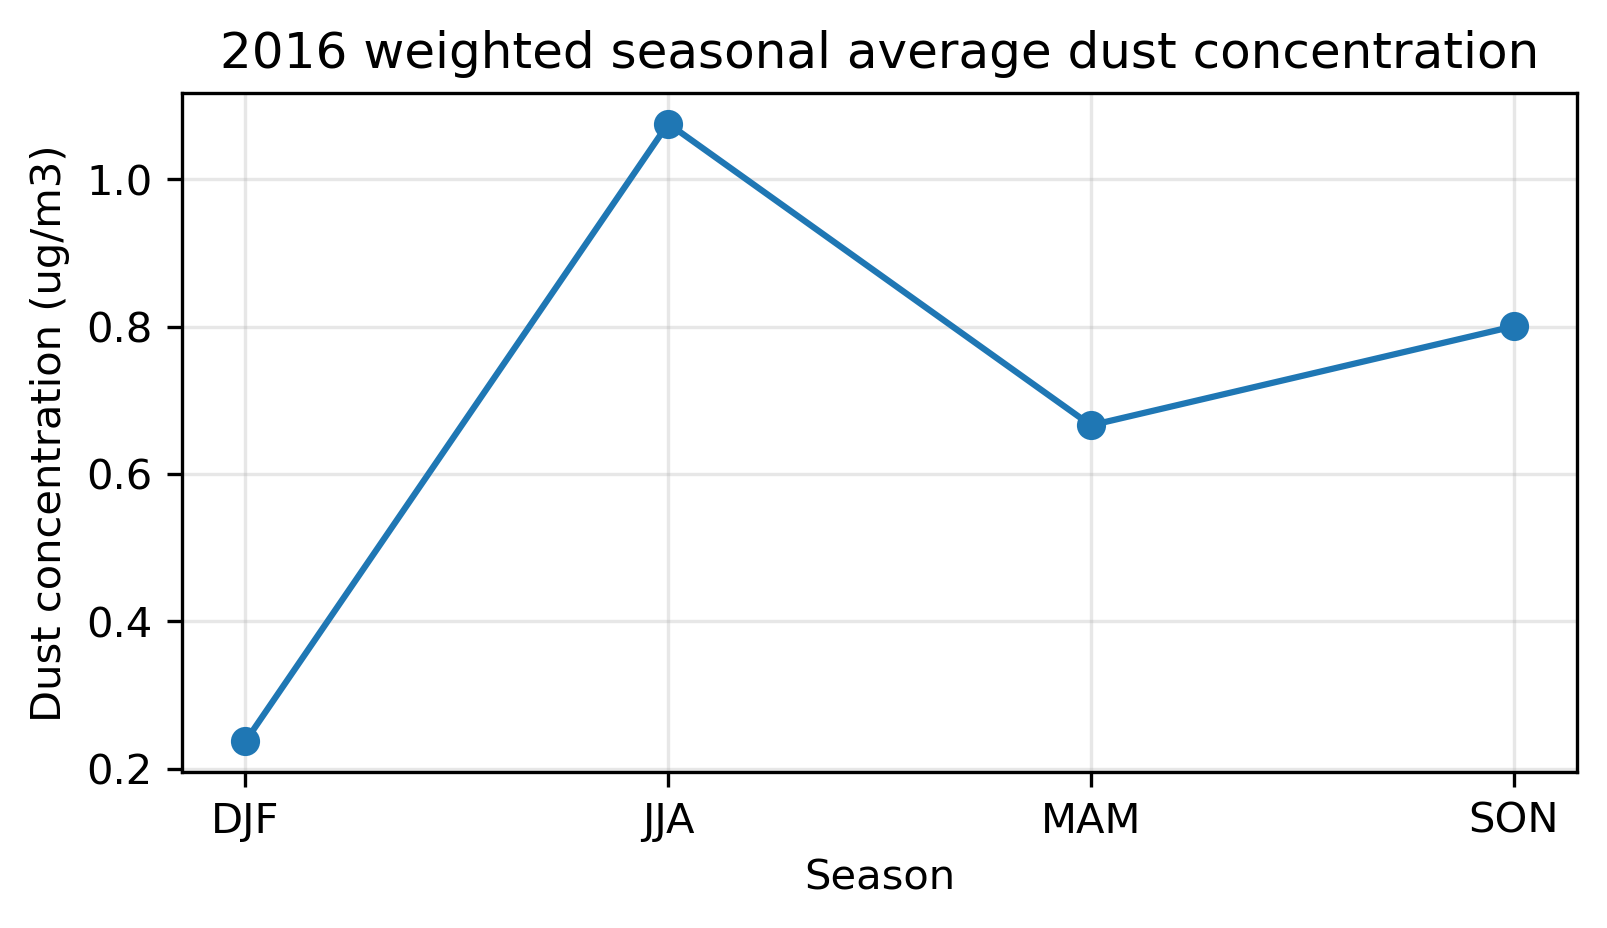

In [5]:
# Code based of xarray example here: http://xarray.pydata.org/en/stable/examples/monthly-means.html
# Compute days per month
month_length = dust_ds.time.dt.days_in_month

# Calculate the weights by grouping by 'time.season'.
weights = (
    month_length.groupby("time.season") / month_length.groupby("time.season").sum()
)

# Test that the sum of the weights for each season is 1.0
np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

# Calculate the weighted average
ds_weighted = (dust_ds * weights).groupby("time.season").sum(dim="time")
ds_weighted = ds_weighted.rio.clip(CA_geom) # Remove extra stuff around CA 

# Compute seasonal mean 
seasonal_mean = ds_weighted.drop("spatial_ref").SOIL.mean(dim=["LAT","LON"])

# Make lineplot 
fig, ax = plt.subplots(figsize=(6,3))
plt.plot(seasonal_mean.season, seasonal_mean.values, marker='o')
plt.ylabel("Dust concentration (ug/m3)")
plt.xlabel("Season")
plt.title(str(year)+" weighted seasonal average dust concentration")
plt.grid(alpha=0.3)
plt.show()

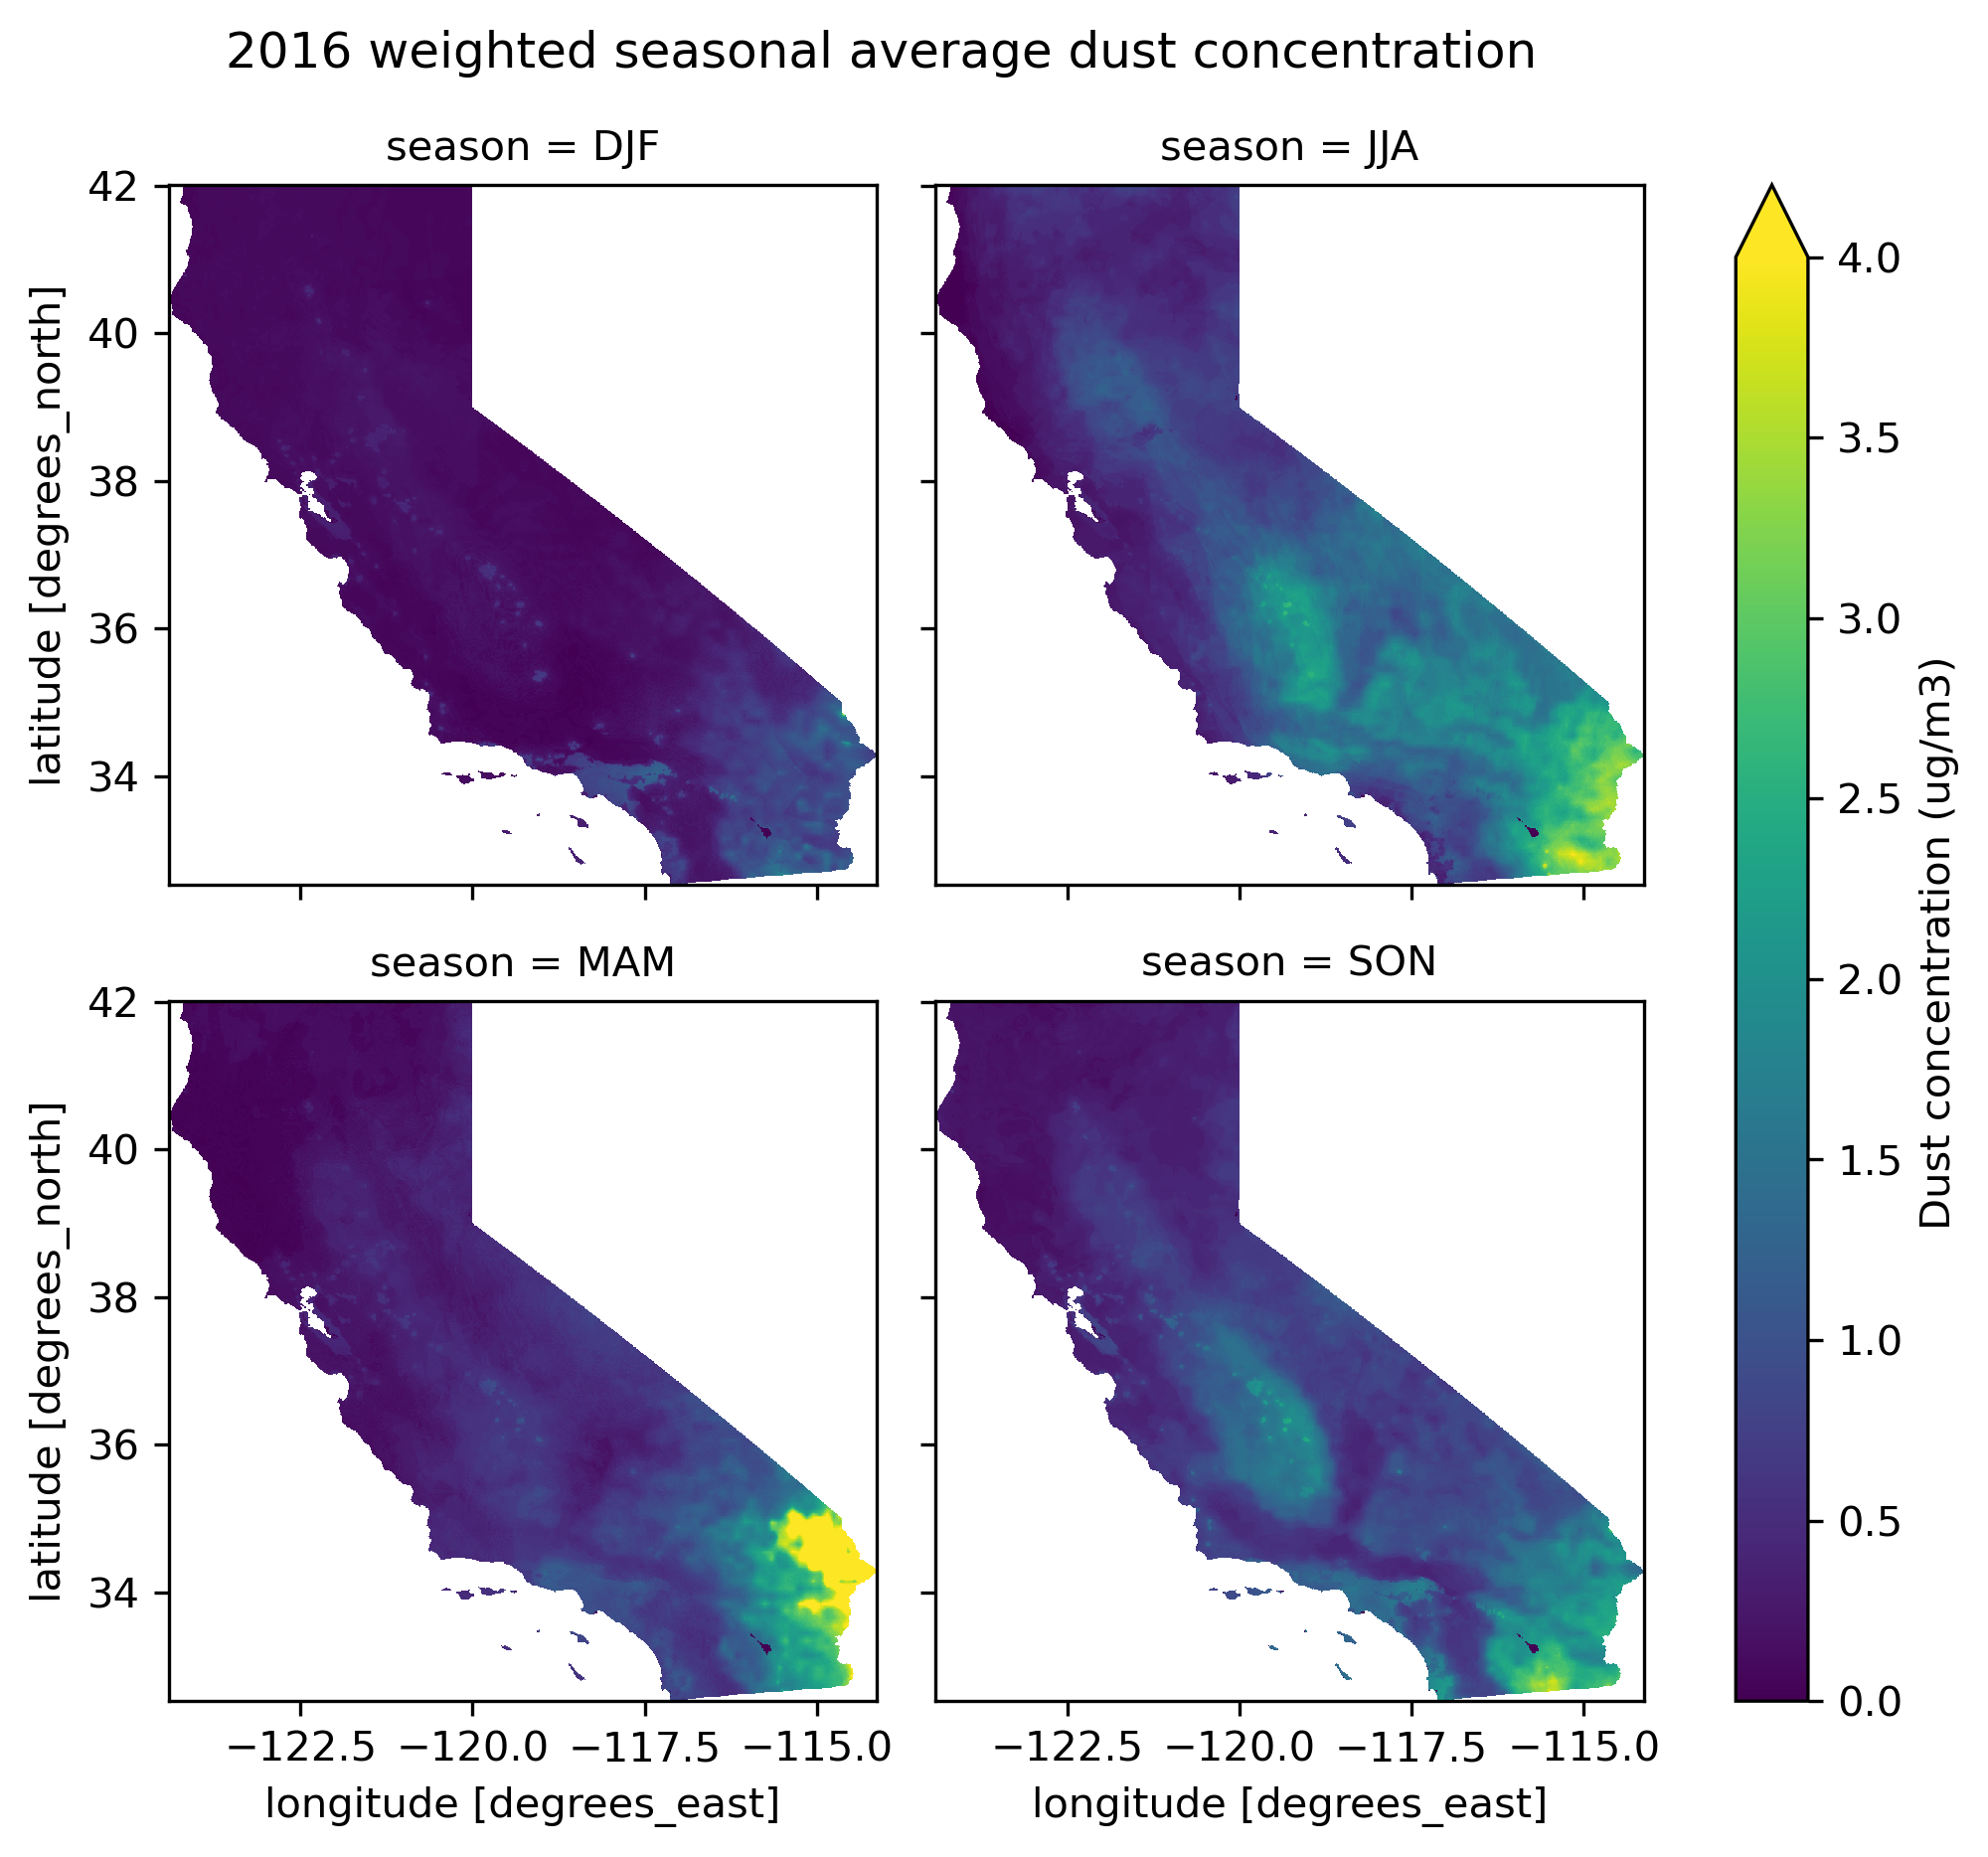

In [6]:
im = ds_weighted.SOIL.drop("spatial_ref").plot(x="LON", y="LAT", col="season",  
                                          vmin=0, vmax=4, col_wrap=2, 
                                          cbar_kwargs={"label": "Dust concentration (ug/m3)"})
for i, ax in enumerate(im.axes.flat):
    cities = {"San Diego": [-117.162, 32.715], "San Francisco": [-122.431, 37.773], "Los Angeles": [-118.243, 34.052], "Sacramento": [-121.494, 38.581], "Fresno": [-119.787, 36.737]}
    for row in relevant_cities.index: 
        city = relevant_cities.loc[row]

plt.suptitle(str(year)+" weighted seasonal average dust concentration", y=1.03, x=0.43)
plt.savefig("data/figs/"+str(year)+"_dust_seasonal_av.png", bbox_inches='tight')
plt.show()

In [ ]:
# hvplot for one month 
month = "August"
data = dust_ds.SOIL.drop("spatial_ref")
data = data.sel(time=month+" "+str(year))
dust_plot_one_month = data.hvplot.quadmesh(features=["coastline"], # Add coastlines 
                                 colorbar=True, clabel="Dust Conc (ug/m3)",# Colorbar settings 
                                 frame_width=400, frame_height=500,
                                 projection=ccrs.PlateCarree(), project=True, 
                                 dynamic=False)

# Set title 
date = pd.to_datetime(data.time.values[0])
dust_plot_one_month.opts(title=date.strftime("%B %Y")+" Dust Concentration")
#hvplot.save(dust_plot_one_month, filename=figs_dir+"/"+date.strftime("%Y%m")+"_dust.png")
display(dust_plot_one_month)

In [ ]:
# Make dust plot 
res = 5 # Reduce resolution
data = dust_ds.SOIL.drop("spatial_ref").assign_coords({"time":pd.to_datetime(dust_ds.time.values).strftime("%m-%Y")})
dust_plot = data[:, ::res, ::res].hvplot.quadmesh(features=["coastline"], # Add coastlines 
                                                  colorbar=True, clim=(0,4), clabel="%PM2.5 Dust",# Colorbar settings 
                                                  frame_width=400, frame_height=500,
                                                  projection=ccrs.PlateCarree(), project=True, 
                                                  dynamic=False)

# Make cities plot
cities_plot = relevant_cities.hvplot(geo=True, hover_cols="Name", color="Black")

# Combine and save figure as html
combined_plot = dust_plot*cities_plot
hv.output(widget_location="bottom")
combined_plot.opts(hv.opts.Layout(shared_axes=True, merge_tools=True))
hvplot.save(combined_plot, filename=figs_dir+"/"+str(year)+"_dust_res_"+str(res)+".html")
display(combined_plot)